In [41]:
import glob
import json
import numpy as np
from rliable import library as rly
from rliable import plot_utils
from rliable import metrics
import matplotlib.pyplot as plt

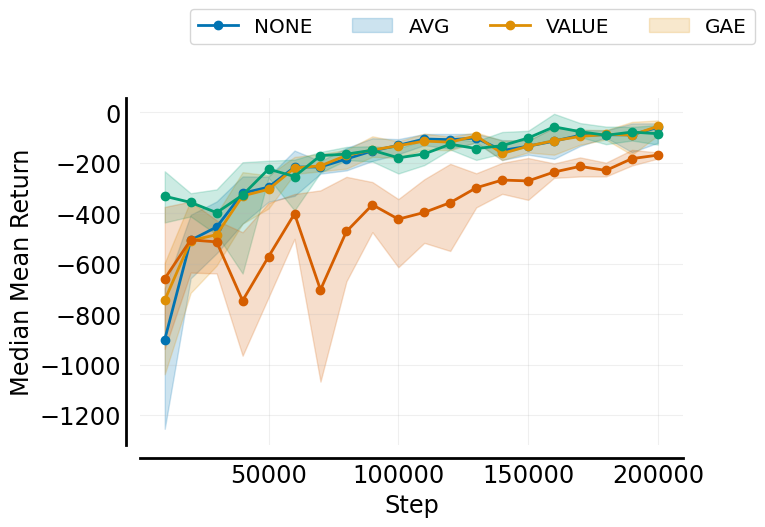

In [ ]:
agent_types = {
    "NONE": "data/none/*/actor_critic.log",
    "AVG": "data/avg/*/actor_critic.log",
    "VALUE": "data/value/*/actor_critic.log",
    "GAE": "data/gae/*/actor_critic.log",
}

scores_dict = {}
steps = None

for agent, path in agent_types.items():
    log_files = glob.glob(path, recursive=True)
    all_curves = []
    all_steps = []
    for log_file in log_files:
        steps_list = []
        rewards = []
        with open(log_file, "r") as f:
            for line in f:
                entry = json.loads(line)
                steps_list.append(entry["step"])
                rewards.append(entry["mean_return"])
        all_steps.append(steps_list)
        all_curves.append(rewards)
    if all_curves:
        min_len = min(len(curve) for curve in all_curves)
        all_curves = np.array([curve[:min_len] for curve in all_curves])
        if steps is None:
            steps = np.array(all_steps[0][:min_len])
        scores_dict[agent] = all_curves[:, None, :]

algorithms = list(scores_dict.keys())

median = lambda scores: np.array(
    [metrics.aggregate_median(scores[..., frame]) for frame in range(scores.shape[-1])]
)
median_scores, median_cis = rly.get_interval_estimates(scores_dict, median, reps=20)

fig, ax = plt.subplots(figsize=(7, 4.5))
plot_utils.plot_sample_efficiency_curve(
    steps,
    median_scores,
    median_cis,
    algorithms=algorithms,
    xlabel="Step",
    ylabel="Median Mean Return",
    ax=ax,
)

legend = fig.legend(
    algorithms,
    loc="upper center",
    fancybox=True,
    ncol=len(algorithms),
    fontsize="x-large",
    bbox_to_anchor=(0.6, 1.1),
)

plt.show()